In [1]:
# # Import the Image module from the PIL library
# from PIL import Image
# import os

# # Function to optimize a single image
# def optimize_image(image_path, output_path):
#     try:
#         # Open the image using the Image.open method
#         image = Image.open(image_path)

#         # Convert the image to RGB format
#         im2 = image.convert('RGB')

#         # Print a message indicating that the image is being optimized
#         # print(f"optimize image '{image_path}'")

#         # Save the optimized image with a quality of 80
#         # The optimize argument is set to True to optimize the file format
#         image.save(output_path, optimize=True, quality=80)
#     except Exception as e:
#         # Print a message if there was a failure to optimize the image
#         print(f"Failed to optimize image '{image_path}': {e}")
#         # Uncomment the next line to remove the image if optimization fails
#         os.remove(image_path)

# # Function to optimize all images in a given folder
# def optimize_image_path(folder, output_folder):
#     # Loop through all files in the folder
#     for filename in os.listdir(folder):
#         # Construct the path to the current file
#         image_path = os.path.join(folder, filename)
#         # Construct the path to the output file
#         output_path = os.path.join(output_folder, filename)
#         # Create the output folder if it does not exist
#         if not os.path.exists(output_folder):
#             os.makedirs(output_folder)
#         # Print the input and output paths for each file
#         print(image_path,output_path)
#         # Call the optimize_image function to optimize the current file
#         optimize_image(image_path,output_path)

# # Uncomment the next block of code to run the optimization process on all files in a folder
# # if __name__ == '__main__':
# folder = '/hpc/home/sz243/aipi540-s23/sz243/Content-filter/images_small/normal'
# for filename in os.listdir(folder):
#     image_path = os.path.join(folder, filename)
#     optimize_image(image_path,image_path)


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# # Transform the data
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# Load the dataset

# Load the data using ImageFolder
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dataset = torchvision.datasets.ImageFolder(root='./images_small',
                                                 transform=data_transform)

# Split the data into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                         shuffle=True, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train': train_loader, 'val': val_loader}

# Store size of training and validation sets
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
print(dataset_sizes)
# Get class names associated with labels
class_names = image_dataset.classes

# data_dir = '/Users/shuai/PycharmProjects/Content-Moderation-for-Social-Media/images'
# image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes


/opt/conda/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


{'train': 26606, 'val': 6652}


In [3]:

# Load the ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda"
if torch.backends.mps.is_available():
    device_name = "mps"

# Move the model to the GPU
device = torch.device(device_name)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay the learning rate by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Keep track of the best model's performance on the validation set
best_acc = 0.0
best_model_wts = model.state_dict()

# # Start the training loop
# for epoch in range(25):
#     print('Epoch {}/{}'.format(epoch, 25 - 1))
#     print('-' * 10)
#
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             scheduler.step()
#             model.train()
#         else:
#             model.eval()

/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from torch.cuda import get_device_name
from torch import tensor


def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device)  # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            # print(get_device_name(device))
            if device_name == 'mps':
                running_corrects = tensor(running_corrects, device='mps', dtype=torch.float32)
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # example = torch.rand(1, 3, 224, 224)
                # traced_script_module = torch.jit.trace(model, example)
                # traced_script_module.save( '../models/best_model_rust.pt')
                torch.save(best_model_wts, './models/best_model.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [5]:
net = train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=20)
# Convert the best model to Torch Script format
# scripted_model = torch.jit.script(net)
# example = torch.rand(1, 3, 224, 224)
# scripted_model = torch.jit.trace(net, example)
# scripted_model.save("../models/best_model_scripted.pt")
# Save the Torch Script model
# torch.jit.save(net, '../models/best_model_scripted.pt')
# net = torch.jit.load('../models/best_model_scripted.pt')
# Load the saved state_dict into the model
# model.load_state_dict(torch.load('./model/best_model.pt'))
# Set the model to evaluation mode
# model.eval()

Epoch 0/19
----------
train Loss: 0.3938 Acc: 0.8486
val Loss: 0.3256 Acc: 0.8812
Epoch 1/19
----------
train Loss: 0.3488 Acc: 0.8672
val Loss: 0.3062 Acc: 0.8860
Epoch 2/19
----------
train Loss: 0.3360 Acc: 0.8707
val Loss: 0.2996 Acc: 0.8909
Epoch 3/19
----------
train Loss: 0.3292 Acc: 0.8739
val Loss: 0.2903 Acc: 0.8942
Epoch 4/19
----------
train Loss: 0.3312 Acc: 0.8732
val Loss: 0.2890 Acc: 0.8933
Epoch 5/19
----------
train Loss: 0.3250 Acc: 0.8749
val Loss: 0.3269 Acc: 0.8782
Epoch 6/19
----------
train Loss: 0.3249 Acc: 0.8756
val Loss: 0.2847 Acc: 0.8978
Epoch 7/19
----------
train Loss: 0.3077 Acc: 0.8830
val Loss: 0.2838 Acc: 0.8970
Epoch 8/19
----------
train Loss: 0.3084 Acc: 0.8815
val Loss: 0.2839 Acc: 0.8969
Epoch 9/19
----------
train Loss: 0.3090 Acc: 0.8810
val Loss: 0.2867 Acc: 0.8967
Epoch 10/19
----------
train Loss: 0.3051 Acc: 0.8828
val Loss: 0.2863 Acc: 0.8952
Epoch 11/19
----------
train Loss: 0.3081 Acc: 0.8830
val Loss: 0.2910 Acc: 0.8915
Epoch 12/19
--

In [6]:
example = torch.rand(1, 3, 224, 224, device=device)
scripted_model = torch.jit.trace(net, example)
scripted_model.save("./models/best_model_scripted.pt")
# Save the Torch Script model
# torch.jit.save(net, '../models/best_model_scripted.pt')
model = torch.jit.load('./models/best_model_scripted.pt')
# Load the saved state_dict into the model
# model.load_state_dict(torch.load('./model/best_model.pt'))
# Set the model to evaluation mode
# model.eval()

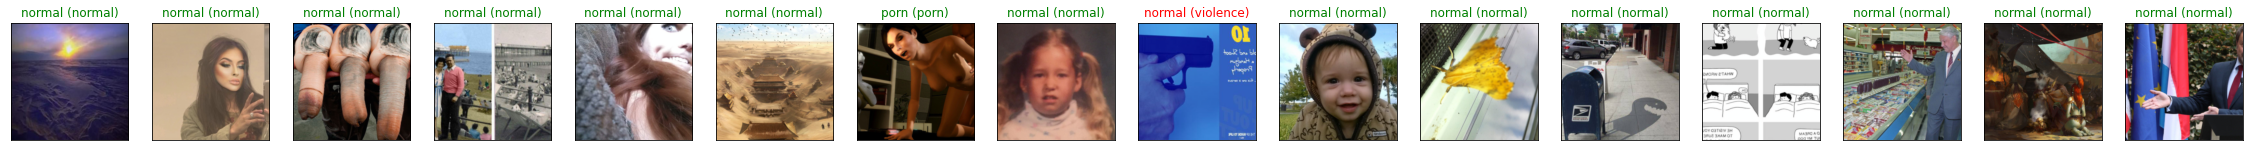

In [7]:
# Display a batch of predictions
def visualize_results(model, dataloader, device):
    model = model.to(device)  # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        # images = torch.rand(1, 3, 224, 224)

        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _, preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 10))
    for idx in np.arange(len(preds) // 2):
        ax = fig.add_subplot(2, len(preds) // 2, idx + 1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                     color=("green" if preds[idx] == labels[idx] else "red"))
    return


visualize_results(net, val_loader, device)

In [8]:
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))
# model.eval()
# example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.trace(model, example)
# traced_script_module.save("../models/resnetmodel.pt")